# Eye Diseases Classification Dataset

#### Load the normalized training, testing and validation datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='training', 
    seed=123
)

validate_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='validation', 
    seed=123
)

validate_batches = tf.data.experimental.cardinality(validate_ds)
test_ds = validate_ds.take(validate_batches // 2)
validate_ds = validate_ds.skip(validate_batches // 2)

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
validate_ds = validate_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


2023-04-18 16:43:36.270249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-18 16:43:36.270299: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-18 16:43:36.270334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-8-20230418-101643): /proc/driver/nvidia/version does not exist
2023-04-18 16:43:36.270696: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


#### Print class names in the dataset

In [2]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


### Visualize the data

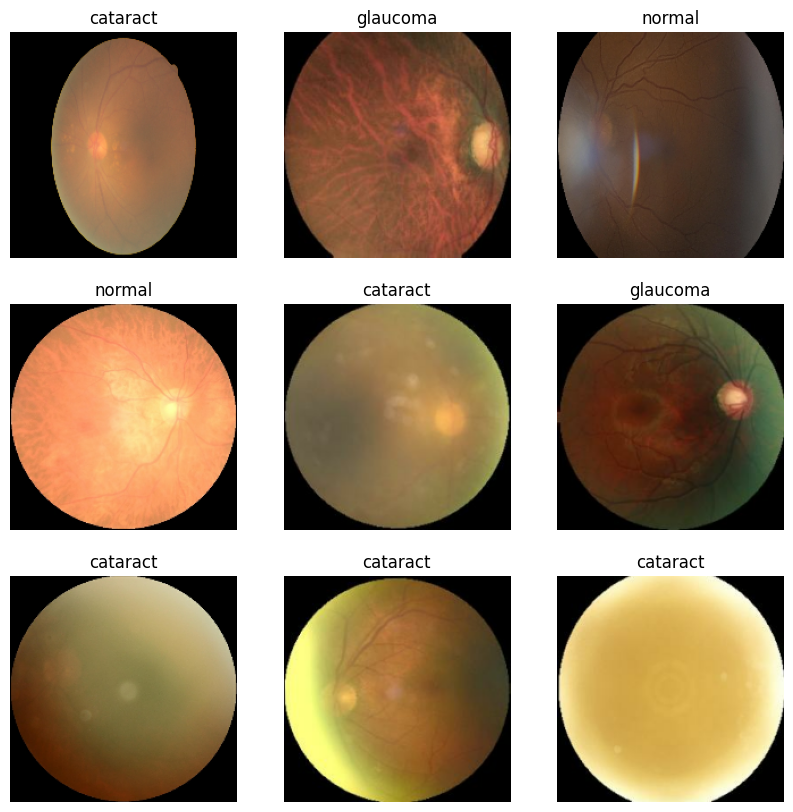

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

### Baseline Model

Create a simple baseline model of 150 hidden neurons and two layers.

In [4]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 50)                6000050   
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 6,005,554
Trainable params: 6,005,554
Non-trainable params: 0
_________________________________________________________________


In [5]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
history = model_base.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

Epoch 1/20
27/27 [==============================] - 19s 540ms/step - loss: 4.6019 - accuracy: 0.4173 - val_loss: 1.6328 - val_accuracy: 0.5512
Epoch 2/20
27/27 [==============================] - 19s 539ms/step - loss: 1.3489 - accuracy: 0.5397 - val_loss: 0.9261 - val_accuracy: 0.5185
Epoch 3/20
27/27 [==============================] - 18s 538ms/step - loss: 0.9131 - accuracy: 0.6215 - val_loss: 0.7452 - val_accuracy: 0.6972
Epoch 4/20
27/27 [==============================] - 18s 535ms/step - loss: 0.7733 - accuracy: 0.6678 - val_loss: 0.8233 - val_accuracy: 0.5882
Epoch 5/20
27/27 [==============================] - 18s 552ms/step - loss: 0.8051 - accuracy: 0.6612 - val_loss: 0.7043 - val_accuracy: 0.7059
Epoch 6/20
27/27 [==============================] - 18s 533ms/step - loss: 0.6954 - accuracy: 0.7069 - val_loss: 0.6795 - val_accuracy: 0.6950
Epoch 7/20
27/27 [==============================] - 18s 535ms/step - loss: 0.7100 - accuracy: 0.7075 - val_loss: 0.7834 - val_accuracy: 0.6841

In [7]:
results = model_base.evaluate(test_ds)

3/3 [==============================] - 3s 25ms/step - loss: 0.6441 - accuracy: 0.7109


In [8]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    fig.show()

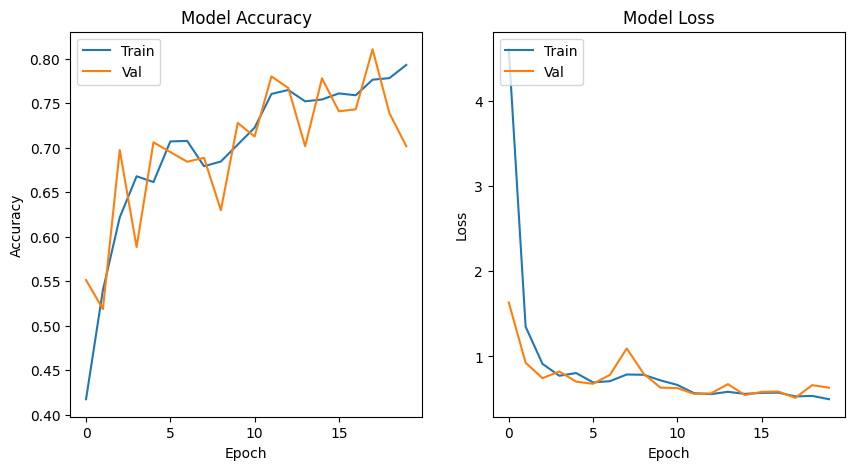

In [9]:
plot_history(history)

### Second Model

Create a model that uses dropout layers and kernel regularizers to reduce the gap between training and validation accuracy.

In [10]:
model_optimize = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_optimize.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 120000)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               15360128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 15,394,180
Trainable params: 15,394,180


In [11]:
model_optimize.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history_optimizer = model_optimize.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

Epoch 1/20
27/27 [==============================] - 21s 619ms/step - loss: 7.9573 - accuracy: 0.3607 - val_loss: 1.0924 - val_accuracy: 0.5011
Epoch 2/20
27/27 [==============================] - 20s 602ms/step - loss: 1.1751 - accuracy: 0.4357 - val_loss: 0.9643 - val_accuracy: 0.5207
Epoch 3/20
27/27 [==============================] - 20s 599ms/step - loss: 1.0959 - accuracy: 0.4870 - val_loss: 0.9278 - val_accuracy: 0.6296
Epoch 4/20
27/27 [==============================] - 20s 618ms/step - loss: 1.0360 - accuracy: 0.5252 - val_loss: 0.8665 - val_accuracy: 0.5664
Epoch 5/20
27/27 [==============================] - 20s 601ms/step - loss: 0.9461 - accuracy: 0.5634 - val_loss: 0.8005 - val_accuracy: 0.6057
Epoch 6/20
27/27 [==============================] - 20s 598ms/step - loss: 0.9469 - accuracy: 0.5679 - val_loss: 0.8720 - val_accuracy: 0.6209
Epoch 7/20
27/27 [==============================] - 20s 610ms/step - loss: 0.9616 - accuracy: 0.5539 - val_loss: 0.8332 - val_accuracy: 0.6057

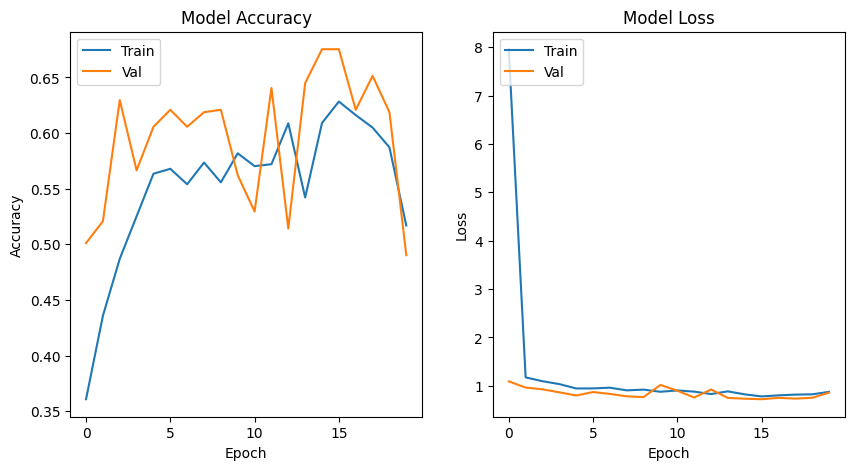

In [13]:
plot_history(history_optimizer)

### Third Model

Create a Convolutional Neural Network (CNN) to improve the accuracy for our overall image classification model. 

In [14]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(60, (3, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 40)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 50)        18050     
                                                                 
 dropout_2 (Dropout)         (None, 97, 97, 50)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 60)        27060     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 60)       0         
 2D)                                                  

In [15]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
cnn_history = cnn_model.fit(
    normalized_ds,
    epochs=5,
    validation_data=validate_ds
)

Epoch 1/5
27/27 [==============================] - 224s 8s/step - loss: 1.3007 - accuracy: 0.4138 - val_loss: 1.1254 - val_accuracy: 0.5120
Epoch 2/5
27/27 [==============================] - 221s 8s/step - loss: 0.9128 - accuracy: 0.5865 - val_loss: 0.8892 - val_accuracy: 0.5861
Epoch 3/5
27/27 [==============================] - 225s 8s/step - loss: 0.8127 - accuracy: 0.6503 - val_loss: 0.7398 - val_accuracy: 0.7081
Epoch 4/5
27/27 [==============================] - 223s 8s/step - loss: 0.6993 - accuracy: 0.7125 - val_loss: 0.7086 - val_accuracy: 0.7081
Epoch 5/5
27/27 [==============================] - 220s 8s/step - loss: 0.6137 - accuracy: 0.7543 - val_loss: 0.5606 - val_accuracy: 0.7821


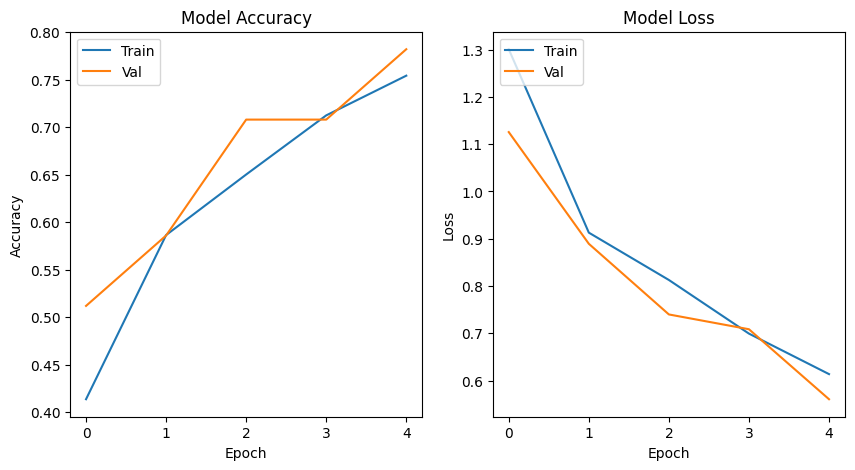

In [17]:
plot_history(cnn_history)